# Generate random data

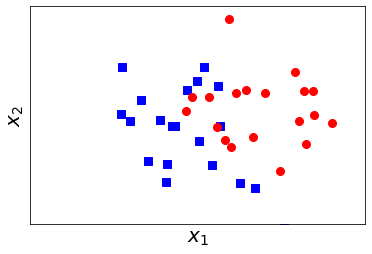

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

np.random.seed(22)

# generate data
means = [[2, 2], [4, 2]]
cov = [[.7, 0], [0, .7]]
N = 20
X0 = np.random.multivariate_normal(means[0], cov, N) # each row is a data point 
X1 = np.random.multivariate_normal(means[1], cov, N)

# plot points
plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize = 8, alpha = 1)
plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize = 8, alpha = 1)
plt.axis('equal')
plt.ylim(0, 4)
plt.xlim(0, 5)

# hide tikcs 
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])

plt.xlabel('$x_1$', fontsize = 20)
plt.ylabel('$x_2$', fontsize = 20)
plt.show()

In [2]:
X = np.vstack((X0, X1))
y = np.vstack((np.ones((N,1 )), -np.ones((N,1 )))).reshape((2*N,))

# Solving by sklearn

In [3]:
from sklearn.svm import SVC
C = 100
clf = SVC(kernel = 'linear', C = C)
clf.fit(X, y) 

w_sklearn = clf.coef_
b_sklearn = clf.intercept_[0]
print(w_sklearn)
print(b_sklearn)

[[-1.87461946 -1.80697358]]
8.496911901960104


# Solving by dual problems

In [4]:
from cvxopt import matrix, solvers

V = np.concatenate((X0.T, -1*X1.T), axis = 1)
K = matrix(V.T.dot(V))
p = matrix(-np.ones((2*N, 1)))

A = matrix(y.reshape((1, 2*N)))
b = matrix(np.ones((1,1)))

G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))
h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))

solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)

l = np.array(sol['x'])
print('lambda = \n', l.T)

lambda = 
 [[1.10363307e-07 9.99999997e+01 1.10521356e-07 6.86057067e-07
  3.71895753e+01 4.70641317e-07 9.99999998e+01 1.14420302e-07
  9.99999999e+01 5.23153867e+01 9.99999993e+01 3.21514892e-07
  9.99999999e+01 9.99999996e+01 1.38207872e-07 9.99999881e+01
  3.38258560e-07 1.45291108e-07 5.53890725e-07 1.42184302e-07
  1.69410950e-07 1.04508884e-07 8.85049541e+01 9.99999997e+01
  9.99999997e+01 7.79977503e-08 2.39277468e-07 1.34294363e-07
  3.73454691e-07 9.99999989e+01 9.99999982e+01 8.34138229e-08
  9.99999998e+01 1.60327797e-07 7.95870911e-08 9.88409801e-08
  9.99999997e+01 8.67786565e-08 8.58485579e-08 9.99999997e+01]]


In [5]:
S = np.where(l > 1e-5)[0]
S2 = np.where(l < .99*C)[0]

M = [val for val in S if val in S2]

XT = X.T
VS = V[:, S]
lS = l[S]

XM = XT[:, M]
yM = y[M]

w_dual = VS.dot(lS).reshape(-1,1)
b_dual = np.mean(yM.T - w_dual.T.dot(XM))
print(w_dual.T)
print(b_dual)

[[-1.87457871 -1.80693793]]
8.49672337699055


# Solving by Hinge Loss

In [6]:
X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data 

Z = np.hstack((X0_bar, - X1_bar)) # as in (22)
lam = 1./C

def cost(w):
    u = w.T.dot(Z) # as in (23)
    return (np.sum(np.maximum(0, 1 - u)) + \
            .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1]

def grad(w):
    u = w.T.dot(Z) # as in (23)
    H = np.where(u < 1)[1]
    ZS = Z[:, H]
    g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w)
    g[-1] -= lam*w[-1]
    return g

eps = 1e-6
def num_grad(w):
    g = np.zeros_like(w)
    for i in range(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps 
        wm[i] -= eps 
        g[i] = (cost(wp) - cost(wm))/(2*eps)
    return g 

w0 = np.random.randn(X0_bar.shape[0], 1) 
g1 = grad(w0)
g2 = num_grad(w0)
diff = np.linalg.norm(g1 - g2)
print('Gradient difference: %f' %diff)

Gradient difference: 0.000000


In [8]:
def gradient_descent(w0, eta):
    w = w0
    it = 0
    while it < 100000:
        it += 1
        g = grad(w)
        w -= eta*g
        if (it % 10000) == 1:
            print('iter %d' %it + ' cost: %f' %cost(w))
        if np.linalg.norm(g) < 1e-5:
            break
    return w

w0 = np.random.randn(X0_bar.shape[0], 1)
w = gradient_descent(w0, 0.001)
w_hinge = w[:-1].reshape(2,1)
b_hinge = w[-1][0]
print(w_hinge.T)
print(b_hinge)

iter 1 cost: 62.790027
iter 10001 cost: 15.755286
iter 20001 cost: 15.744316
iter 30001 cost: 15.724746
iter 40001 cost: 15.710856
iter 50001 cost: 15.694064
iter 60001 cost: 15.681147
iter 70001 cost: 15.673648
iter 80001 cost: 15.664280
iter 90001 cost: 15.664696
[[-1.86263592 -1.79456742]]
8.449351707360563


# Result Visualisation

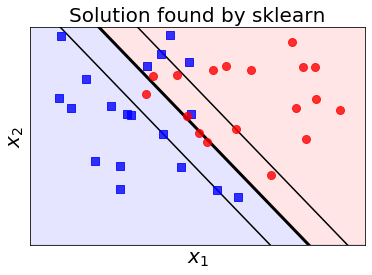

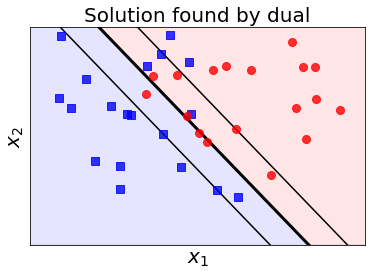

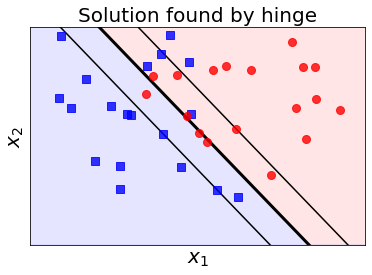

In [9]:
def myplot(X0, X1, w, b, tit):
    fig, ax = plt.subplots()
    w0 = w[0]
    w1 = w[1]
    x1 = np. arange(-10, 10, 0.1)
    y1 = - w0/w1*x1 - b/w1
    y2 = - w0/w1*x1 - (b-1)/w1
    y3 = - w0/w1*x1 - (b+1)/w1
    plt.plot(x1, y1, 'k', linewidth = 3)
    plt.plot(x1, y2, 'k')
    plt.plot(x1, y3, 'k')
    
    # equal axis and lim
    plt.axis('equal')
    plt.ylim(0, 3)
    plt.xlim(2, 4)
    
    # hide ticks
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_ticks([])
    cur_axes.axes.get_yaxis().set_ticks([])
    
    # fill two regions
    y4 = 20 * x1
    plt.fill_between(x1, y1, color = 'blue', alpha = .1)
    plt.fill_between(x1, y1, y4, color = 'red', alpha = .1)
    
    plt.xlabel('$x_1$', fontsize = 20)
    plt.ylabel('$x_2$', fontsize = 20)
    plt.title('Solution found by ' + tit, fontsize = 20)
    
    # show data
    plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize = 8, alpha = .8)
    plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize = 8, alpha = .8)
    plt.show()
    
myplot(X0, X1, w_sklearn.T, b_sklearn, 'sklearn')
myplot(X0, X1, w_dual, b_dual, 'dual')
myplot(X0, X1, w_hinge, b_hinge, 'hinge') 

In [10]:
# Compare weights calculated by 3 different methods
print(w_sklearn, b_sklearn)
print(w_dual.T, b_dual) 
print(w_hinge.T, b_hinge)

[[-1.87461946 -1.80697358]] 8.496911901960104
[[-1.87457871 -1.80693793]] 8.49672337699055
[[-1.86263592 -1.79456742]] 8.449351707360563
